# Exploratory Spatio-Temporal Data Analysis
# Part 2 - Descriptive Statistics - Yearly Summary Statistics

In [11]:
import gc

import numpy as np
import pandas as pd
import polars as pl

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from statsmodels.tsa.seasonal import seasonal_decompose

import folium
from mpl_toolkits.basemap import Basemap

%matplotlib inline

In [12]:
# ds = xr.open_dataset('data/preprocessed_power_nasa_data.nc')

In [13]:
# ds

In [14]:
polars_df = pl.read_parquet("/workspace/soil-ml-modeling-pipeline/ml-modeling-pipeline/data/02_intermediate/preprocessed_power_nasa_data.parquet")

In [15]:
polars_df

shape: (6_082_324, 17)
┌──────────────┬──────┬────────┬───────────┬───┬───────────┬───────────┬─────────────┬─────────────┐
│ time         ┆ lat  ┆ lon    ┆ EVPTRNS   ┆ … ┆ GWETTOP   ┆ CLOUD_AMT ┆ ALLSKY_SFC_ ┆ PRECTOTCORR │
│ ---          ┆ ---  ┆ ---    ┆ ---       ┆   ┆ ---       ┆ ---       ┆ SW_DWN      ┆ _mm         │
│ datetime[ns] ┆ f64  ┆ f64    ┆ f64       ┆   ┆ f64       ┆ f64       ┆ ---         ┆ ---         │
│              ┆      ┆        ┆           ┆   ┆           ┆           ┆ f64         ┆ f64         │
╞══════════════╪══════╪════════╪═══════════╪═══╪═══════════╪═══════════╪═════════════╪═════════════╡
│ 2001-01-01   ┆ -4.5 ┆ 39.375 ┆ 20.554688 ┆ … ┆ 0.40625   ┆ 43.009766 ┆ 263.890625  ┆ 0.63943     │
│ 00:00:00     ┆      ┆        ┆           ┆   ┆           ┆           ┆             ┆             │
│ 2001-01-01   ┆ -4.0 ┆ 29.375 ┆ 73.023438 ┆ … ┆ 0.8515625 ┆ 94.381348 ┆ 190.95752   ┆ 2.88367     │
│ 00:00:00     ┆      ┆        ┆           ┆   ┆           ┆           ┆             ┆             │
│ 2001-01-01   ┆ -4.0 ┆ 30.0   ┆ 51.226562 ┆ … ┆ 0.7890625 ┆ 93.867188 ┆ 197.355469  ┆ 5.45587     │
│ 00:00:00     ┆      ┆        ┆           ┆   ┆           ┆           ┆             ┆             │
│ 2001-01-01   ┆ -4.0 ┆ 38.75  ┆ 8.21875   ┆ … ┆ 0.453125  ┆ 44.986328 ┆ 242.912109  ┆ 0.715677    │
│ 00:00:00     ┆      ┆        ┆           ┆   ┆           ┆           ┆             ┆             │
│ 2001-01-01   ┆ -4.0 ┆ 39.375 ┆ 4.1875    ┆ … ┆ 0.4140625 ┆ 45.098633 ┆ 244.987305  ┆ 0.254067    │
│ 00:00:00     ┆      ┆        ┆           ┆   ┆           ┆           ┆             ┆             │
│ …            ┆ …    ┆ …      ┆ …         ┆ … ┆ …         ┆ …         ┆ …           ┆ …           │
│ 2024-01-01   ┆ 17.0 ┆ 37.5   ┆ 0.0625    ┆ … ┆ 0.2578125 ┆ 4.707031  ┆ 216.121094  ┆ 0.419501    │
│ 00:00:00     ┆      ┆        ┆           ┆   ┆           ┆           ┆             ┆             │
│ 2024-01-01   ┆ 17.0 ┆ 38.125 ┆ 1.0       ┆ … ┆ 0.3828125 ┆ 27.514648 ┆ 175.00293   ┆ 1.74302     │
│ 00:00:00     ┆      ┆        ┆           ┆   ┆           ┆           ┆             ┆             │
│ 2024-01-01   ┆ 17.0 ┆ 38.75  ┆ 1.25      ┆ … ┆ 0.453125  ┆ 44.016602 ┆ 150.183594  ┆ 3.529251    │
│ 00:00:00     ┆      ┆        ┆           ┆   ┆           ┆           ┆             ┆             │
│ 2024-01-01   ┆ 17.5 ┆ 38.125 ┆ 2.515625  ┆ … ┆ 0.40625   ┆ 33.563477 ┆ 166.175781  ┆ 1.420858    │
│ 00:00:00     ┆      ┆        ┆           ┆   ┆           ┆           ┆             ┆             │
│ 2024-01-01   ┆ 17.5 ┆ 38.75  ┆ 0.8984375 ┆ … ┆ 0.4296875 ┆ 51.099609 ┆ 141.804688  ┆ 1.832297    │
│ 00:00:00     ┆      ┆        ┆           ┆   ┆           ┆           ┆             ┆             │
└──────────────┴──────┴────────┴───────────┴───┴───────────┴───────────┴─────────────┴─────────────┘

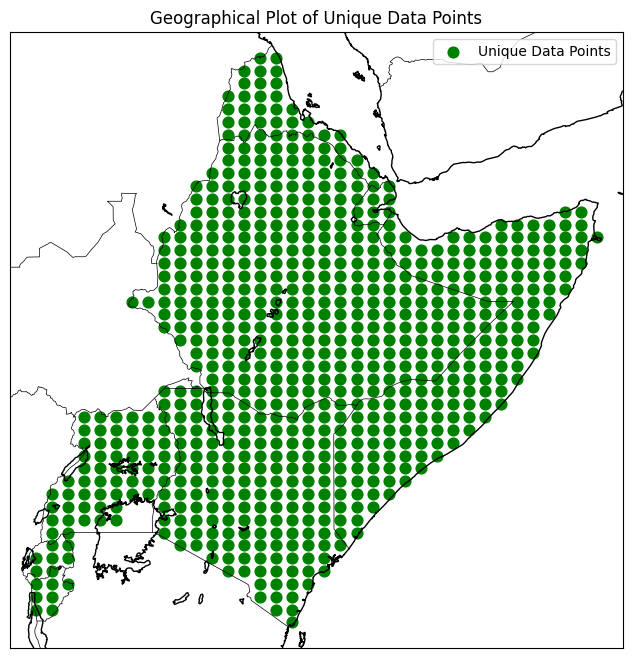

In [20]:
def plot_geographical_data(polars_df: pl.DataFrame):
    """
    Plots unique geographical data points on a map from a Polars DataFrame containing latitude and longitude.

    Parameters:
    - polars_df (pl.DataFrame): A Polars DataFrame with 'lat' and 'lon' columns.

    Author:
    - Adam Przychodni
    """
    # Ensure the DataFrame has the necessary columns
    if not {'lat', 'lon'}.issubset(polars_df.columns):
        raise ValueError("DataFrame must contain 'lat' and 'lon' columns")

    # Select the latitude and longitude columns and get unique pairs
    unique_coords = polars_df.select(['lat', 'lon']).unique()

    # Extract longitude and latitude columns from the unique coordinates
    lons = unique_coords.get_column('lon').to_numpy()
    lats = unique_coords.get_column('lat').to_numpy()

    # Set up the plot with a specified size
    fig, ax = plt.subplots(figsize=(12, 8))

    # Create a Basemap instance with a cylindrical projection
    m = Basemap(projection='cyl', llcrnrlon=lons.min() - 1, llcrnrlat=lats.min() - 1,
                urcrnrlon=lons.max() + 1, urcrnrlat=lats.max() + 1, resolution='i', ax=ax)

    # Draw coastlines and countries for better map visualization
    m.drawcoastlines()
    m.drawcountries()

    # Convert latitude and longitude to map projection coordinates
    x, y = m(lons, lats)

    # Plot the data points with a green color, 'o' marker, and size of 60
    m.scatter(x, y, color='green', label='Unique Data Points', marker='o', s=60)

    # Add a legend and a title to the plot
    plt.legend()
    plt.title('Geographical Plot of Unique Data Points')

    # Display the plot
    plt.show()

    # Close the plot to free up memory
    plt.close(fig)
    
    # Explicitly delete variables and collect garbage
    del m, x, y, lons, lats, unique_coords, fig, ax
    gc.collect()

# Example usage:
plot_geographical_data(polars_df)


## Descriptive statistics

### Summmary statistics

#### Yearly Summary Statistics

In [16]:
# Select columns to exclude from summary statistics
columns_to_exclude = ["time", "lat", "lon"]

# Define the aggregations to perform for each of the other columns dynamically
aggregations = []
for col in polars_df.columns:
    if col not in columns_to_exclude:
        aggregations.extend([
            pl.col(col).mean().alias(f"{col}_mean"),
            pl.col(col).std().alias(f"{col}_std"),
            pl.col(col).min().alias(f"{col}_min"),
            pl.col(col).max().alias(f"{col}_max"),
            pl.col(col).median().alias(f"{col}_median"),
            pl.col(col).quantile(0.25).alias(f"{col}_q25"),
            pl.col(col).quantile(0.75).alias(f"{col}_q75")
        ])

# Group by year and aggregate
annual_stats_df = polars_df.group_by(pl.col("time").dt.year()).agg(aggregations)
annual_stats_df = annual_stats_df.sort("time")

In [17]:
annual_stats_df

shape: (24, 99)
┌──────┬────────────┬────────────┬────────────┬───┬────────────┬───────────┬───────────┬───────────┐
│ time ┆ EVPTRNS_me ┆ EVPTRNS_st ┆ EVPTRNS_mi ┆ … ┆ PRECTOTCOR ┆ PRECTOTCO ┆ PRECTOTCO ┆ PRECTOTCO │
│ ---  ┆ an         ┆ d          ┆ n          ┆   ┆ R_mm_max   ┆ RR_mm_med ┆ RR_mm_q25 ┆ RR_mm_q75 │
│ i32  ┆ ---        ┆ ---        ┆ ---        ┆   ┆ ---        ┆ ian       ┆ ---       ┆ ---       │
│      ┆ f64        ┆ f64        ┆ f64        ┆   ┆ f64        ┆ ---       ┆ f64       ┆ f64       │
│      ┆            ┆            ┆            ┆   ┆            ┆ f64       ┆           ┆           │
╞══════╪════════════╪════════════╪════════════╪═══╪════════════╪═══════════╪═══════════╪═══════════╡
│ 2001 ┆ 9.625896   ┆ 19.310685  ┆ 0.0        ┆ … ┆ 88.330672  ┆ 0.189508  ┆ 0.001001  ┆ 1.601963  │
│ 2002 ┆ 8.639961   ┆ 17.982871  ┆ 0.0        ┆ … ┆ 123.850907 ┆ 0.185922  ┆ 0.000558  ┆ 1.516055  │
│ 2003 ┆ 8.783016   ┆ 17.353542  ┆ 0.0        ┆ … ┆ 151.137301 ┆ 0.124964  ┆ 0.0       ┆ 1.440381  │
│ 2004 ┆ 7.841843   ┆ 17.074883  ┆ 0.0        ┆ … ┆ 79.27022   ┆ 0.186005  ┆ 0.000845  ┆ 1.553678  │
│ 2005 ┆ 8.245631   ┆ 17.639489  ┆ 0.0        ┆ … ┆ 103.100356 ┆ 0.097711  ┆ 0.0       ┆ 1.288421  │
│ …    ┆ …          ┆ …          ┆ …          ┆ … ┆ …          ┆ …         ┆ …         ┆ …         │
│ 2020 ┆ 17.335423  ┆ 23.819588  ┆ 0.0        ┆ … ┆ 1126.54025 ┆ 0.270055  ┆ 0.005316  ┆ 2.247262  │
│      ┆            ┆            ┆            ┆   ┆ 9          ┆           ┆           ┆           │
│ 2021 ┆ 14.111987  ┆ 22.391678  ┆ 0.0        ┆ … ┆ 1548.48180 ┆ 0.159532  ┆ 0.001202  ┆ 1.540607  │
│      ┆            ┆            ┆            ┆   ┆ 4          ┆           ┆           ┆           │
│ 2022 ┆ 13.087307  ┆ 21.472154  ┆ 0.0        ┆ … ┆ 1028.22544 ┆ 0.164755  ┆ 0.001745  ┆ 1.408331  │
│      ┆            ┆            ┆            ┆   ┆ 3          ┆           ┆           ┆           │
│ 2023 ┆ 17.888054  ┆ 23.987565  ┆ 0.0        ┆ … ┆ 456.143332 ┆ 0.241356  ┆ 0.001634  ┆ 2.257823  │
│ 2024 ┆ 20.772002  ┆ 23.920427  ┆ 0.0        ┆ … ┆ 25.64274   ┆ 0.258299  ┆ 0.001539  ┆ 1.642533  │
└──────┴────────────┴────────────┴────────────┴───┴────────────┴───────────┴───────────┴───────────┘

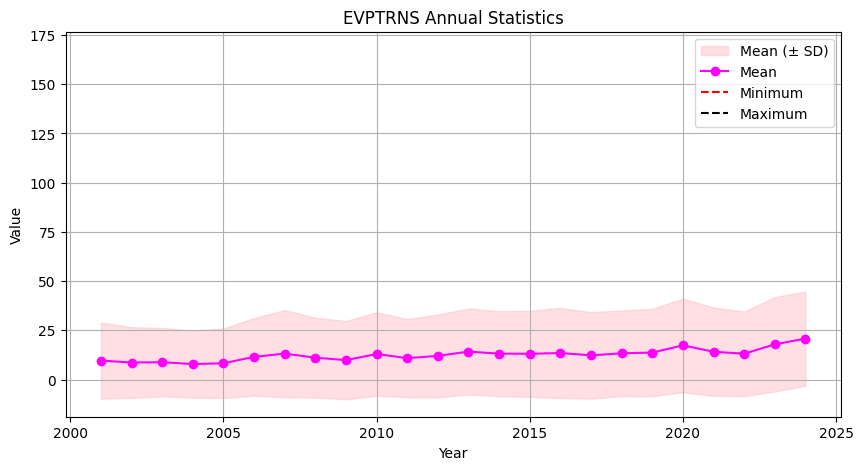

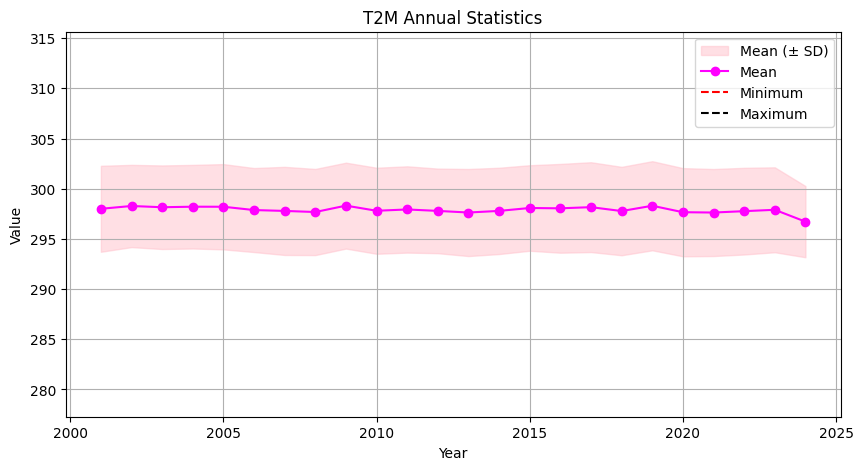

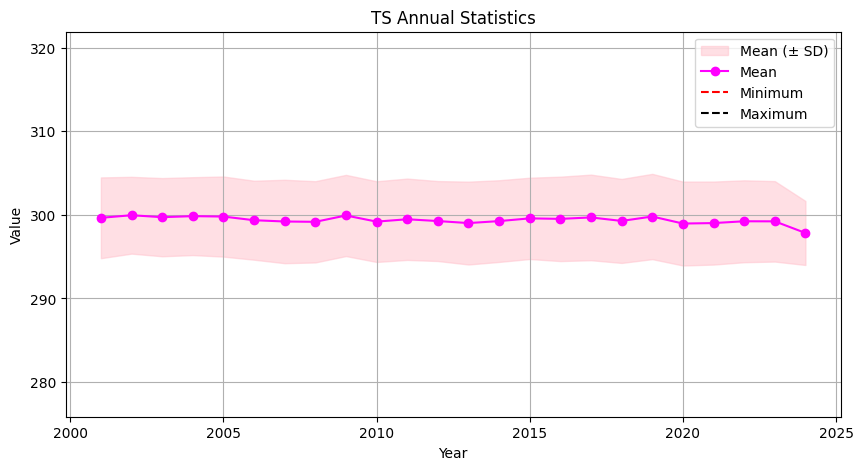

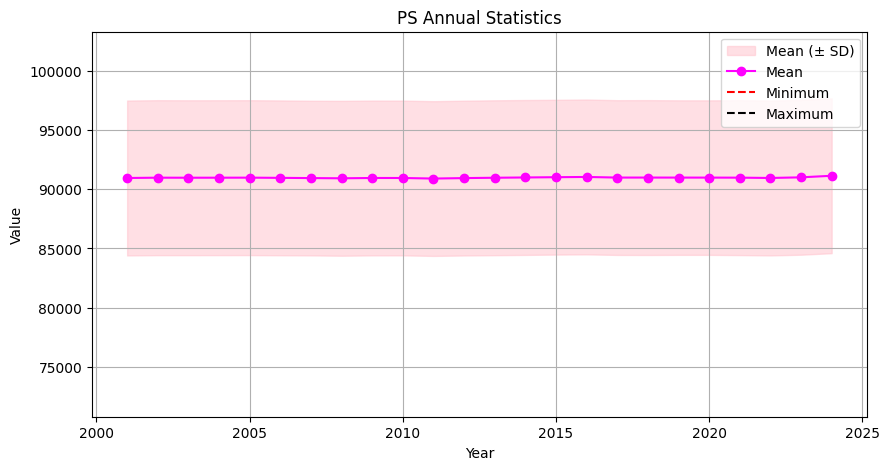

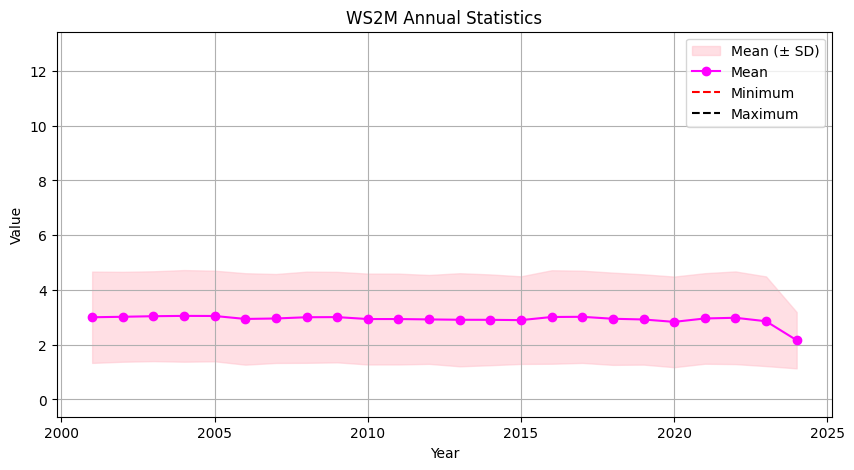

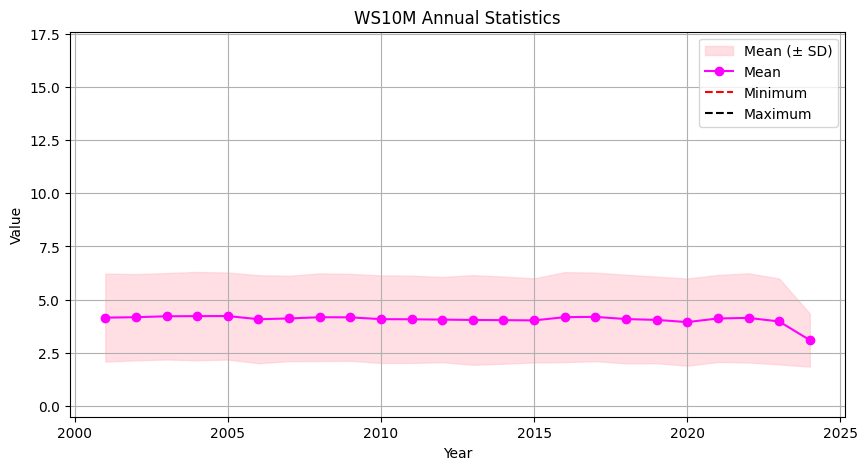

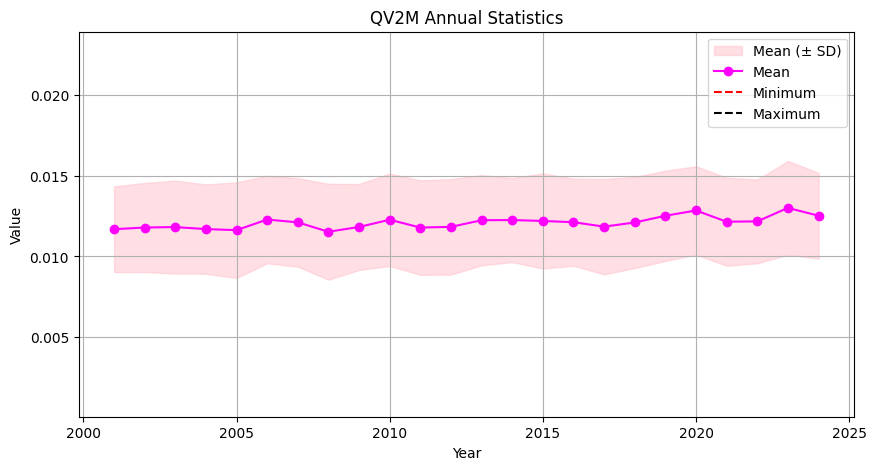

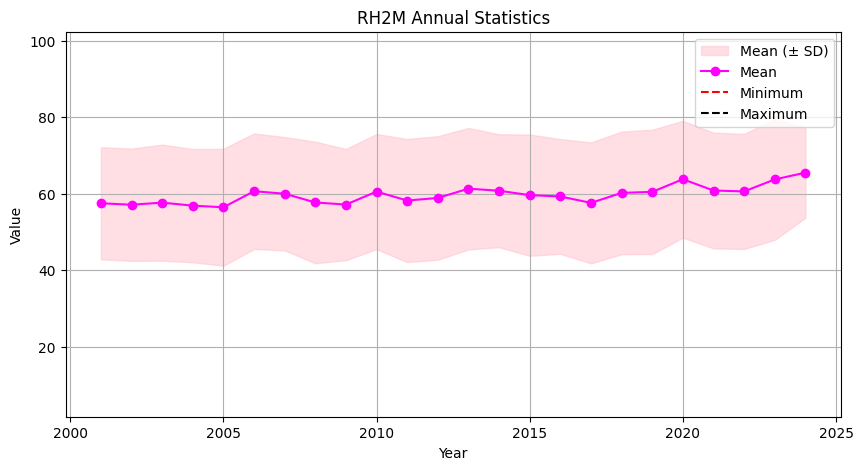

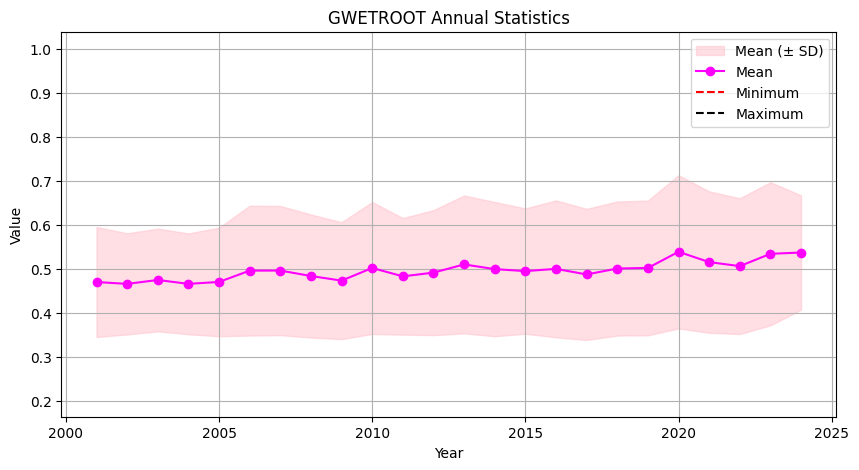

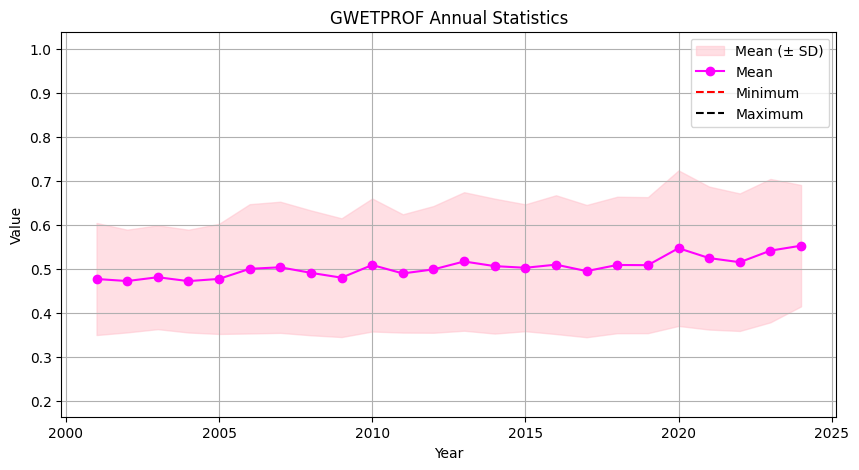

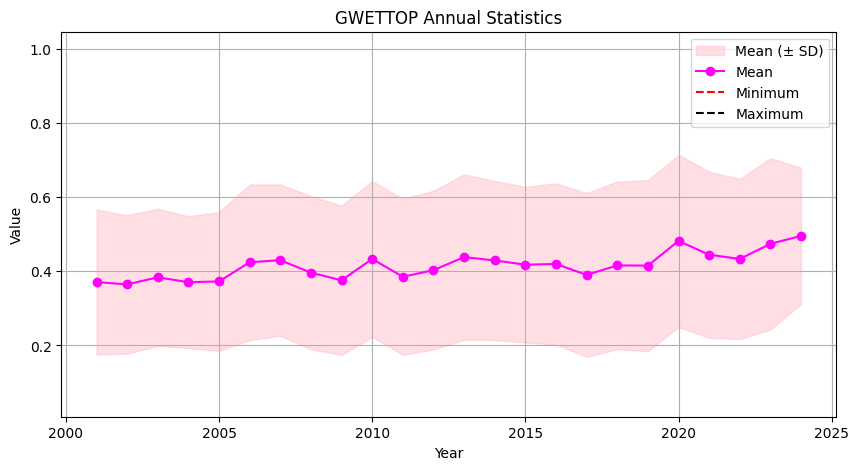

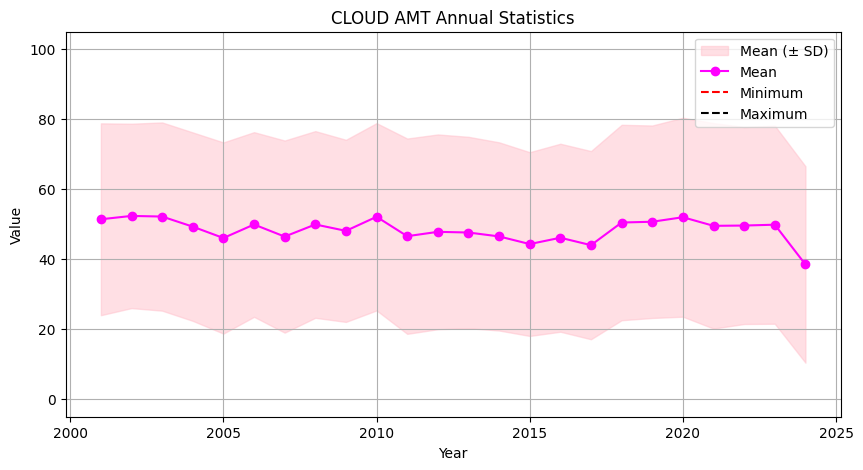

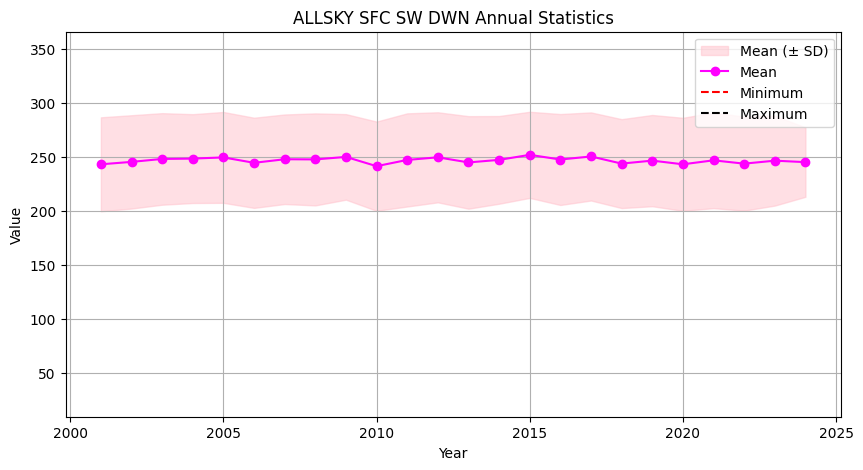

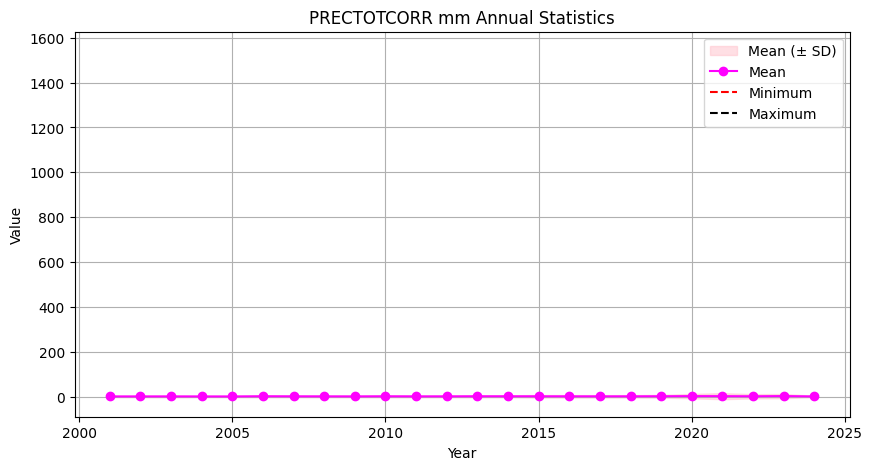

In [25]:
import matplotlib.pyplot as plt
import polars as pl

def plot_annual_stats(annual_stats_df):
    """
    This function will loop through each group of variable statistics in the DataFrame and
    create a separate plot for each one, maintaining the order they appear in the DataFrame.

    Args:
    - annual_stats_df (pl.DataFrame): DataFrame with annual statistics for each variable.
    """
    # List all variables by identifying prefixes from the mean columns specifically,
    # and maintain their original order
    variables = [col.split('_mean')[0] for col in annual_stats_df.columns if '_mean' in col]

    # Plot each variable
    for var in variables:
        try:
            # Extract relevant statistics for the current variable
            time = annual_stats_df['time']
            mean = annual_stats_df[f'{var}_mean']
            std = annual_stats_df[f'{var}_std']
            min_val = annual_stats_df[f'{var}_min']
            max_val = annual_stats_df[f'{var}_max']

            # Calculate mean ± std for the shaded area
            mean_plus_std = mean + std
            mean_minus_std = mean - std

            # Plotting
            plt.figure(figsize=(10, 5))
            plt.fill_between(time, mean_minus_std, mean_plus_std, color='pink', alpha=0.5, label='Mean (± SD)')
            plt.plot(time, mean, 'o-', color='magenta', label='Mean')
            plt.hlines(min_val, time, time, colors='red', linestyles='dashed', label='Minimum')
            plt.hlines(max_val, time, time, colors='black', linestyles='dashed', label='Maximum')

            # Adding labels and title
            plt.title(f"{var.replace('_', ' ')} Annual Statistics")
            plt.xlabel('Year')
            plt.ylabel('Value')
            plt.legend()
            plt.grid(True)
            plt.show()

        except KeyError as e:
            print(f"Could not plot variable {var}: {e}")

# Assuming 'annual_stats_df' is your dataframe, you can call the function directly
plot_annual_stats(annual_stats_df)


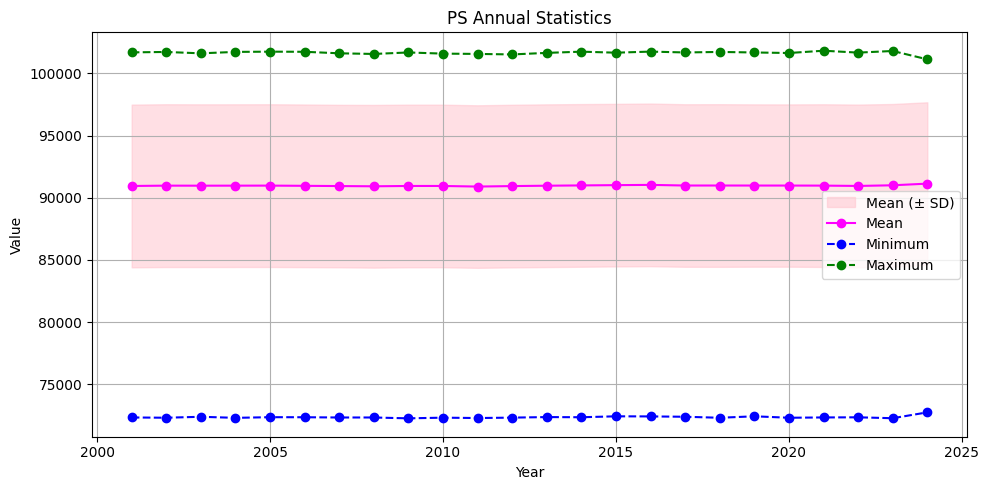

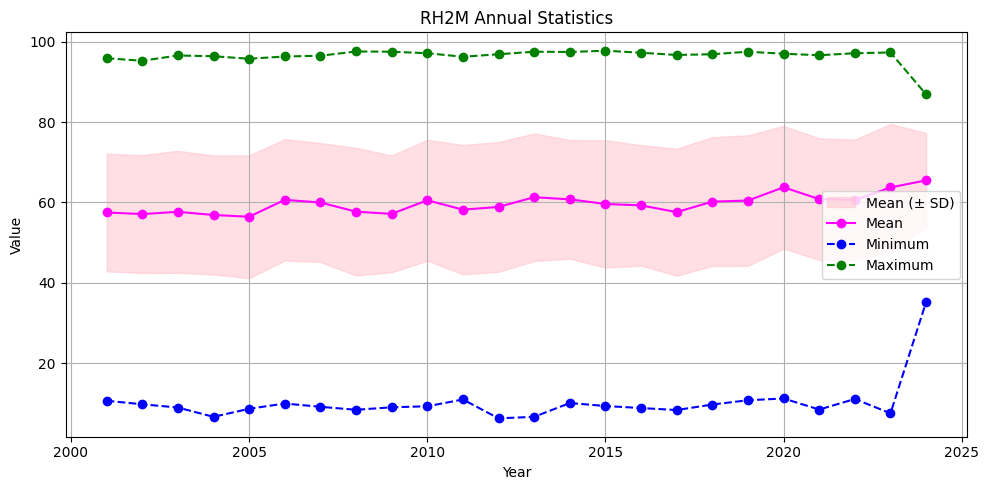

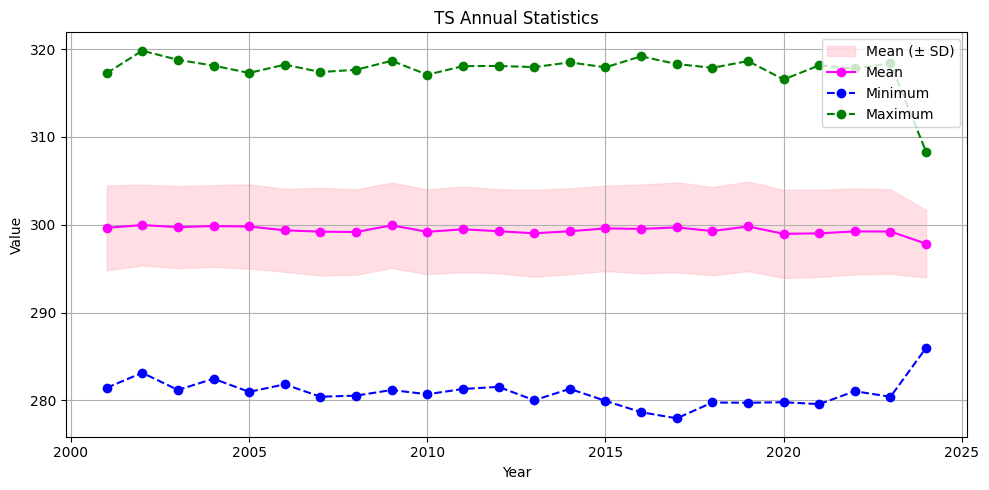

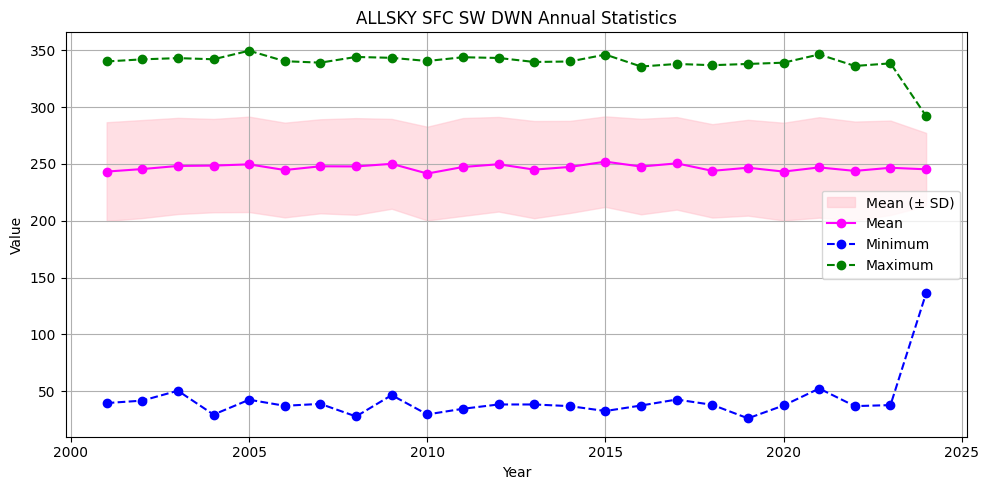

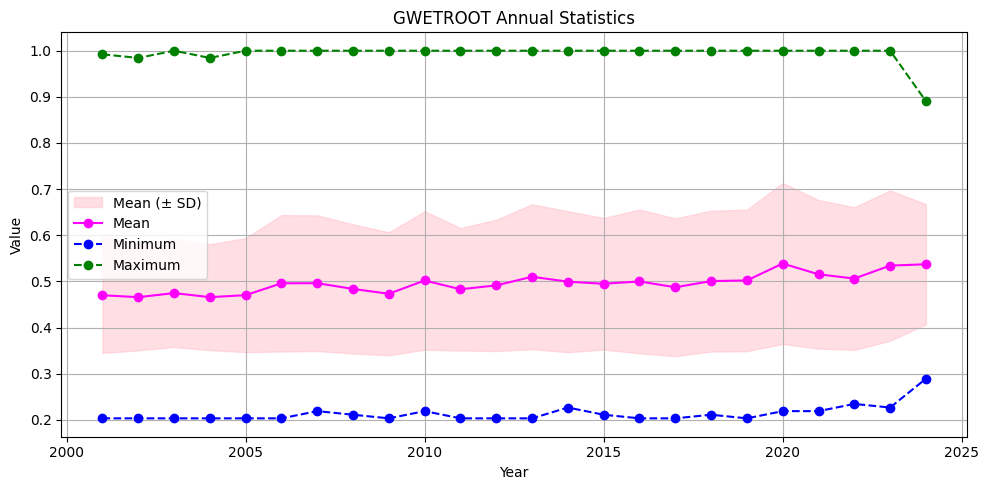

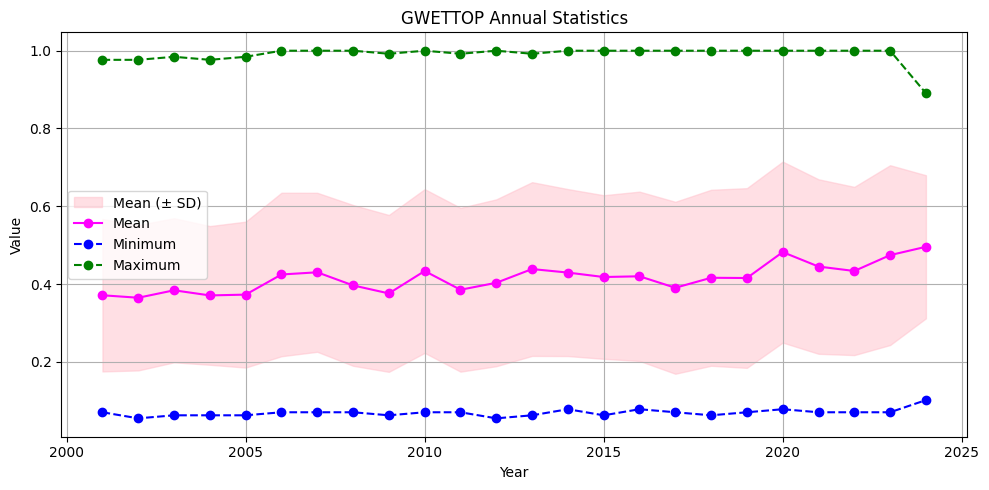

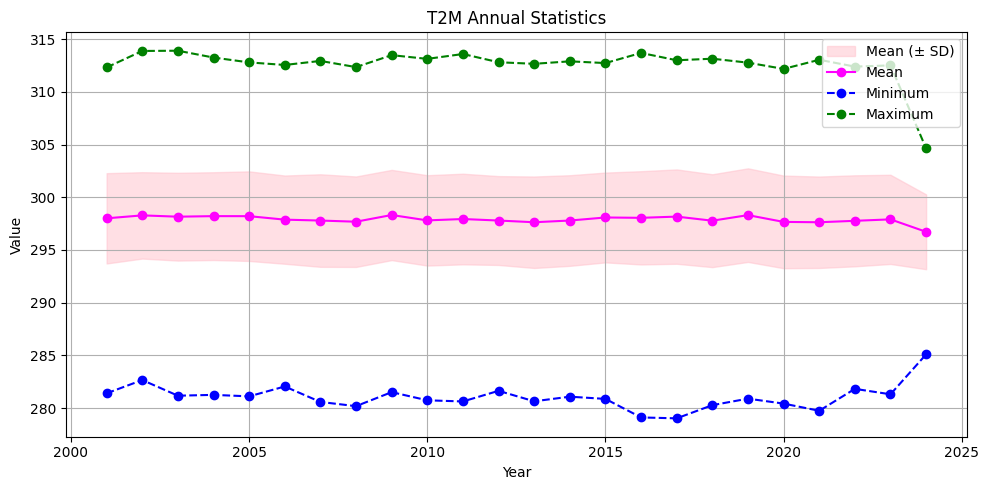

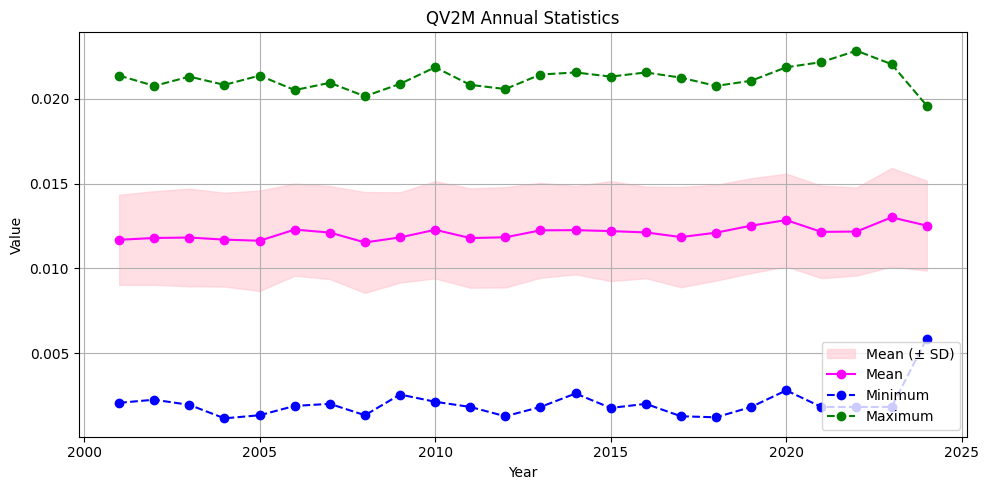

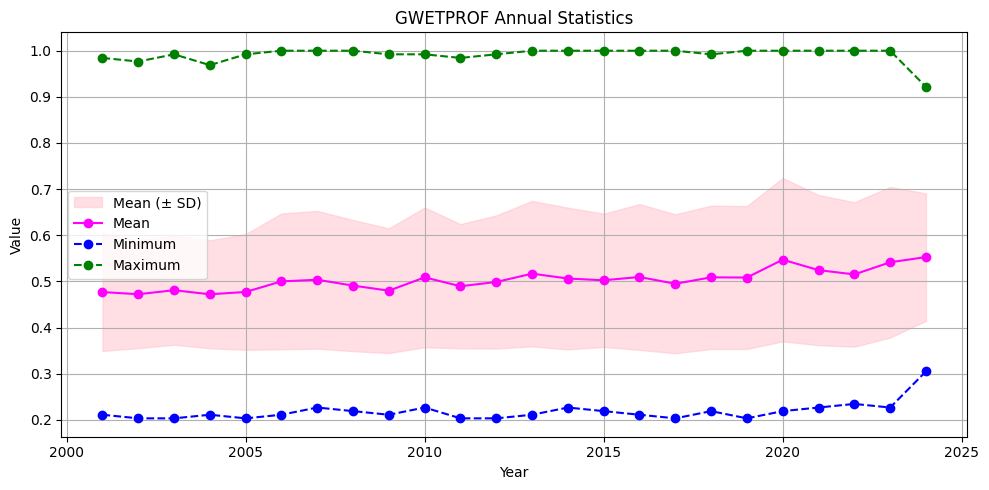

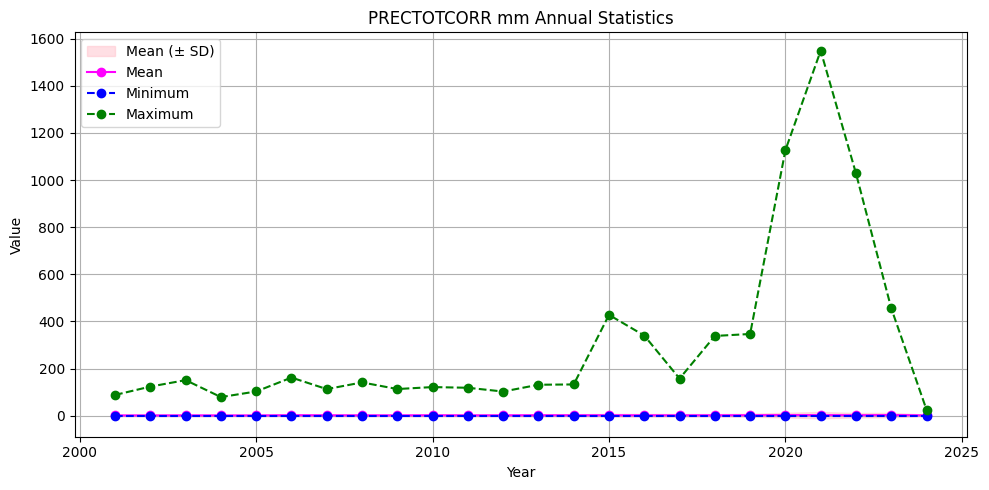

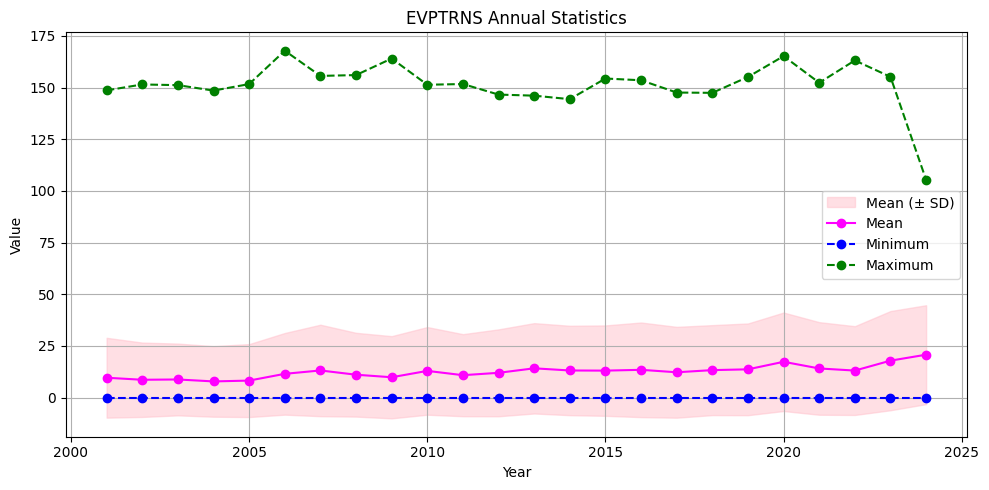

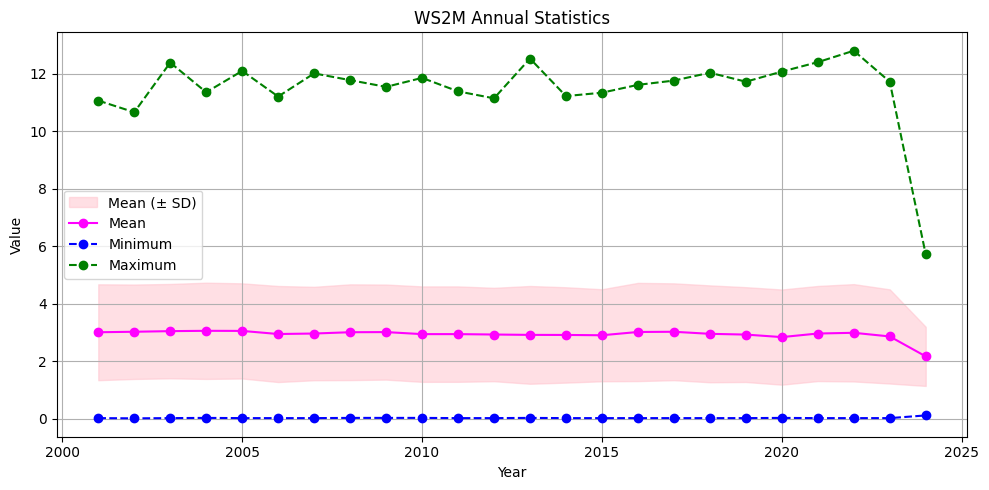

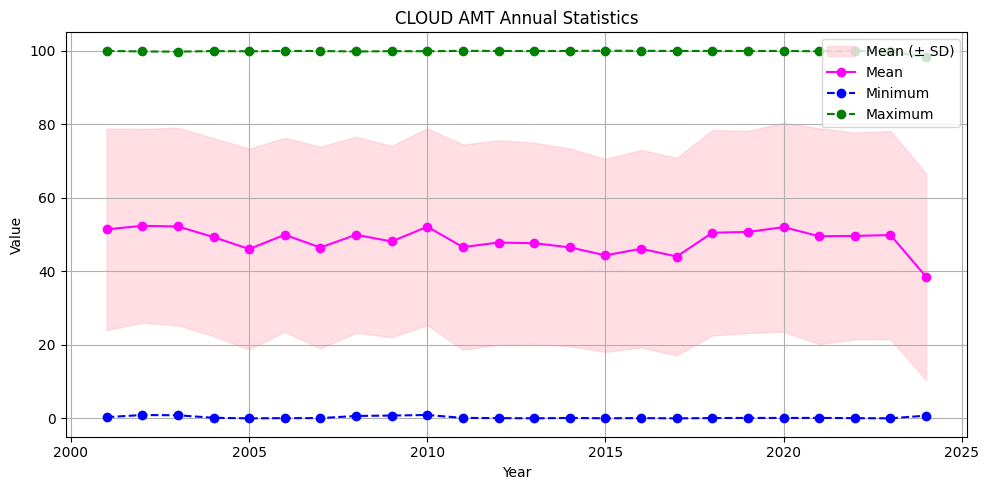

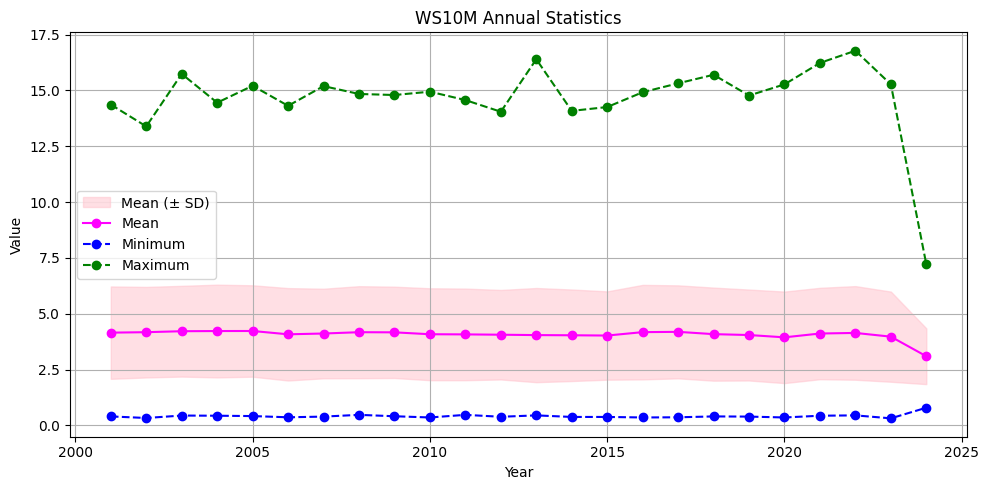

In [22]:
import matplotlib.pyplot as plt
import polars as pl

def plot_annual_stats_with_min_max(annual_stats_df):
    """
    This function will loop through each group of variable statistics in the DataFrame and
    create a separate plot for each one, maintaining the order they appear in the DataFrame.

    Args:
    - annual_stats_df (pl.DataFrame): DataFrame with annual statistics for each variable.
    """
    # Identify all the unique variable names by removing known statistical suffixes
    suffixes = ['mean', 'std', 'min', 'max', 'median', 'q25', 'q75']
    variables = set('_'.join(col.split('_')[:-1]) for col in annual_stats_df.columns if col.split('_')[-1] in suffixes)

    # Plot each variable
    for var in variables:
        try:
            # Extract the relevant columns for the current variable
            time = annual_stats_df['time']
            mean = annual_stats_df[f'{var}_mean']
            std = annual_stats_df[f'{var}_std']
            min_val = annual_stats_df[f'{var}_min']
            max_val = annual_stats_df[f'{var}_max']

            # Calculate mean ± std for the shaded area
            mean_plus_std = mean + std
            mean_minus_std = mean - std

            # Plotting
            plt.figure(figsize=(10, 5))
            plt.fill_between(time, mean_minus_std, mean_plus_std, color='pink', alpha=0.5, label='Mean (± SD)')
            plt.plot(time, mean, 'o-', color='magenta', label='Mean')

            # Check if min and max are different from mean
            if not all(mean == min_val):
                plt.plot(time, min_val, 'o--', color='blue', label='Minimum')
            if not all(mean == max_val):
                plt.plot(time, max_val, 'o--', color='green', label='Maximum')

            # Adding labels and title
            plt.title(f"{var.replace('_', ' ')} Annual Statistics")
            plt.xlabel('Year')
            plt.ylabel('Value')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()  # Adjust the plot to ensure everything fits without overlap
            plt.show()

        except KeyError as e:
            print(f"Could not plot variable {var}: {e}")

# Call the function with your dataframe
plot_annual_stats_with_min_max(annual_stats_df)


In [27]:
polars_df.head()

shape: (5, 17)
┌──────────────┬──────┬────────┬───────────┬───┬───────────┬───────────┬─────────────┬─────────────┐
│ time         ┆ lat  ┆ lon    ┆ EVPTRNS   ┆ … ┆ GWETTOP   ┆ CLOUD_AMT ┆ ALLSKY_SFC_ ┆ PRECTOTCORR │
│ ---          ┆ ---  ┆ ---    ┆ ---       ┆   ┆ ---       ┆ ---       ┆ SW_DWN      ┆ _mm         │
│ datetime[ns] ┆ f64  ┆ f64    ┆ f64       ┆   ┆ f64       ┆ f64       ┆ ---         ┆ ---         │
│              ┆      ┆        ┆           ┆   ┆           ┆           ┆ f64         ┆ f64         │
╞══════════════╪══════╪════════╪═══════════╪═══╪═══════════╪═══════════╪═════════════╪═════════════╡
│ 2001-01-01   ┆ -4.5 ┆ 39.375 ┆ 20.554688 ┆ … ┆ 0.40625   ┆ 43.009766 ┆ 263.890625  ┆ 0.63943     │
│ 00:00:00     ┆      ┆        ┆           ┆   ┆           ┆           ┆             ┆             │
│ 2001-01-01   ┆ -4.0 ┆ 29.375 ┆ 73.023438 ┆ … ┆ 0.8515625 ┆ 94.381348 ┆ 190.95752   ┆ 2.88367     │
│ 00:00:00     ┆      ┆        ┆           ┆   ┆           ┆           ┆             ┆             │
│ 2001-01-01   ┆ -4.0 ┆ 30.0   ┆ 51.226562 ┆ … ┆ 0.7890625 ┆ 93.867188 ┆ 197.355469  ┆ 5.45587     │
│ 00:00:00     ┆      ┆        ┆           ┆   ┆           ┆           ┆             ┆             │
│ 2001-01-01   ┆ -4.0 ┆ 38.75  ┆ 8.21875   ┆ … ┆ 0.453125  ┆ 44.986328 ┆ 242.912109  ┆ 0.715677    │
│ 00:00:00     ┆      ┆        ┆           ┆   ┆           ┆           ┆             ┆             │
│ 2001-01-01   ┆ -4.0 ┆ 39.375 ┆ 4.1875    ┆ … ┆ 0.4140625 ┆ 45.098633 ┆ 244.987305  ┆ 0.254067    │
│ 00:00:00     ┆      ┆        ┆           ┆   ┆           ┆           ┆             ┆             │
└──────────────┴──────┴────────┴───────────┴───┴───────────┴───────────┴─────────────┴─────────────┘

In [38]:
import polars as pl

# Ensure that 'polars_df' is loaded with the proper data structure as shown previously

# Convert the 'time' column from datetime to a year if it's not already in the correct format
polars_df_years = polars_df.with_columns(
    pl.col("time").dt.year().alias("year")
)

# Group by year, latitude, and longitude to calculate mean for each variable
yearly_averages_by_location = (
    polars_df_years
    .group_by(["year", "lat", "lon"])
    .agg([pl.mean(col).alias(f"{col}_avg") for col in polars_df_years.columns if col not in ["time", "lat", "lon", "year"]])
)
# Sort the DataFrame by year, latitude, and longitude
sorted_yearly_averages = yearly_averages_by_location.sort(["year", "lat", "lon"])

sorted_yearly_averages



shape: (17_376, 17)
┌──────┬──────┬────────┬─────────────┬───┬─────────────┬──────────────┬──────────────┬─────────────┐
│ year ┆ lat  ┆ lon    ┆ EVPTRNS_avg ┆ … ┆ GWETTOP_avg ┆ CLOUD_AMT_av ┆ ALLSKY_SFC_S ┆ PRECTOTCORR │
│ ---  ┆ ---  ┆ ---    ┆ ---         ┆   ┆ ---         ┆ g            ┆ W_DWN_avg    ┆ _mm_avg     │
│ i32  ┆ f64  ┆ f64    ┆ f64         ┆   ┆ f64         ┆ ---          ┆ ---          ┆ ---         │
│      ┆      ┆        ┆             ┆   ┆             ┆ f64          ┆ f64          ┆ f64         │
╞══════╪══════╪════════╪═════════════╪═══╪═════════════╪══════════════╪══════════════╪═════════════╡
│ 2001 ┆ -4.5 ┆ 39.375 ┆ 8.973716    ┆ … ┆ 0.395826    ┆ 45.387337    ┆ 233.854848   ┆ 1.517132    │
│ 2001 ┆ -4.0 ┆ 29.375 ┆ 44.546511   ┆ … ┆ 0.78262     ┆ 77.044609    ┆ 201.990221   ┆ 3.922206    │
│ 2001 ┆ -4.0 ┆ 30.0   ┆ 30.02911    ┆ … ┆ 0.713613    ┆ 73.563939    ┆ 208.481127   ┆ 2.535872    │
│ 2001 ┆ -4.0 ┆ 38.75  ┆ 2.994906    ┆ … ┆ 0.427697    ┆ 50.926097    ┆ 223.174294   ┆ 1.50105     │
│ 2001 ┆ -4.0 ┆ 39.375 ┆ 6.061323    ┆ … ┆ 0.421789    ┆ 47.079685    ┆ 227.888843   ┆ 1.682283    │
│ …    ┆ …    ┆ …      ┆ …           ┆ … ┆ …           ┆ …            ┆ …            ┆ …           │
│ 2024 ┆ 17.0 ┆ 37.5   ┆ 0.0625      ┆ … ┆ 0.2578125   ┆ 4.707031     ┆ 216.121094   ┆ 0.419501    │
│ 2024 ┆ 17.0 ┆ 38.125 ┆ 1.0         ┆ … ┆ 0.3828125   ┆ 27.514648    ┆ 175.00293    ┆ 1.74302     │
│ 2024 ┆ 17.0 ┆ 38.75  ┆ 1.25        ┆ … ┆ 0.453125    ┆ 44.016602    ┆ 150.183594   ┆ 3.529251    │
│ 2024 ┆ 17.5 ┆ 38.125 ┆ 2.515625    ┆ … ┆ 0.40625     ┆ 33.563477    ┆ 166.175781   ┆ 1.420858    │
│ 2024 ┆ 17.5 ┆ 38.75  ┆ 0.8984375   ┆ … ┆ 0.4296875   ┆ 51.099609    ┆ 141.804688   ┆ 1.832297    │
└──────┴──────┴────────┴─────────────┴───┴─────────────┴──────────────┴──────────────┴─────────────┘

In [9]:
# def plot_yearly_data(yearly_data):
#     """
#     Plots yearly climate data on a geographical map of Ethiopia using a colormap that highlights soil wetness variations.

#     Parameters:
#     - yearly_data (xarray.Dataset): The dataset containing the climate data, specifically resampled to yearly averages.

#     This function visualizes soil wetness for each year on a geographical map of Ethiopia.
#     """
#     # Define a custom colormap from red (dry) to blue (wet)
#     colors = ["red", "orange", "yellow", "green", "blue"]
#     cmap = LinearSegmentedColormap.from_list("custom", colors, N=256)

#     num_years = len(yearly_data.timestamp)
#     ncols = 3  # A smaller number of columns for yearly data, assuming fewer years than months
#     nrows = (num_years + ncols - 1) // ncols
#     fig = plt.figure(figsize=(18, 3 * nrows), dpi=200)  # Adjust size and DPI for clarity

#     # Define the geographic extent of Ethiopia
#     ethiopia_extent = [33, 48, 3, 15]  # [lon_min, lon_max, lat_min, lat_max]

#     for i, time in enumerate(yearly_data.timestamp):
#         ax = fig.add_subplot(nrows, ncols, i + 1, projection=ccrs.PlateCarree())
#         ax.coastlines(resolution='10m', color='black', linewidth=1)
#         ax.add_feature(cfeature.BORDERS, linestyle=':')
#         ax.set_extent(ethiopia_extent, crs=ccrs.PlateCarree())  # Set the extent to cover Ethiopia
        
#         # Plot the data
#         soil_wetness = yearly_data.sel(timestamp=time)
#         p = soil_wetness.plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False,
#                               vmin=0, vmax=1, cmap=cmap)  # Applying the custom colormap
        
#         ax.set_title(time.dt.strftime('%Y').values)  # Year as the title

#     plt.tight_layout()
    
#     # Add a colorbar with settings
#     fig.subplots_adjust(right=0.9)
#     cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
#     fig.colorbar(p, cax=cbar_ax, label='Soil Wetness', extend='both')

#     plt.show()


### What is Surface Soil Wetness

Surface Soil Wetness Daily refers to the percentage of soil moisture present in the surface layer, typically ranging from 0 cm to 5 cm below the ground surface. A value of 0 signifies completely dry soil devoid of water, while a value of 1 represents soil that is fully saturated with water. This metric is essential for understanding immediate moisture conditions at the surface level, influencing factors like plant growth, erosion, and runoff.


In [12]:
# Computing monthly averages specifically for the GWETROOT variable
yearly_soil_wetness = ds['GWETTOP'].resample(timestamp='YE').mean()

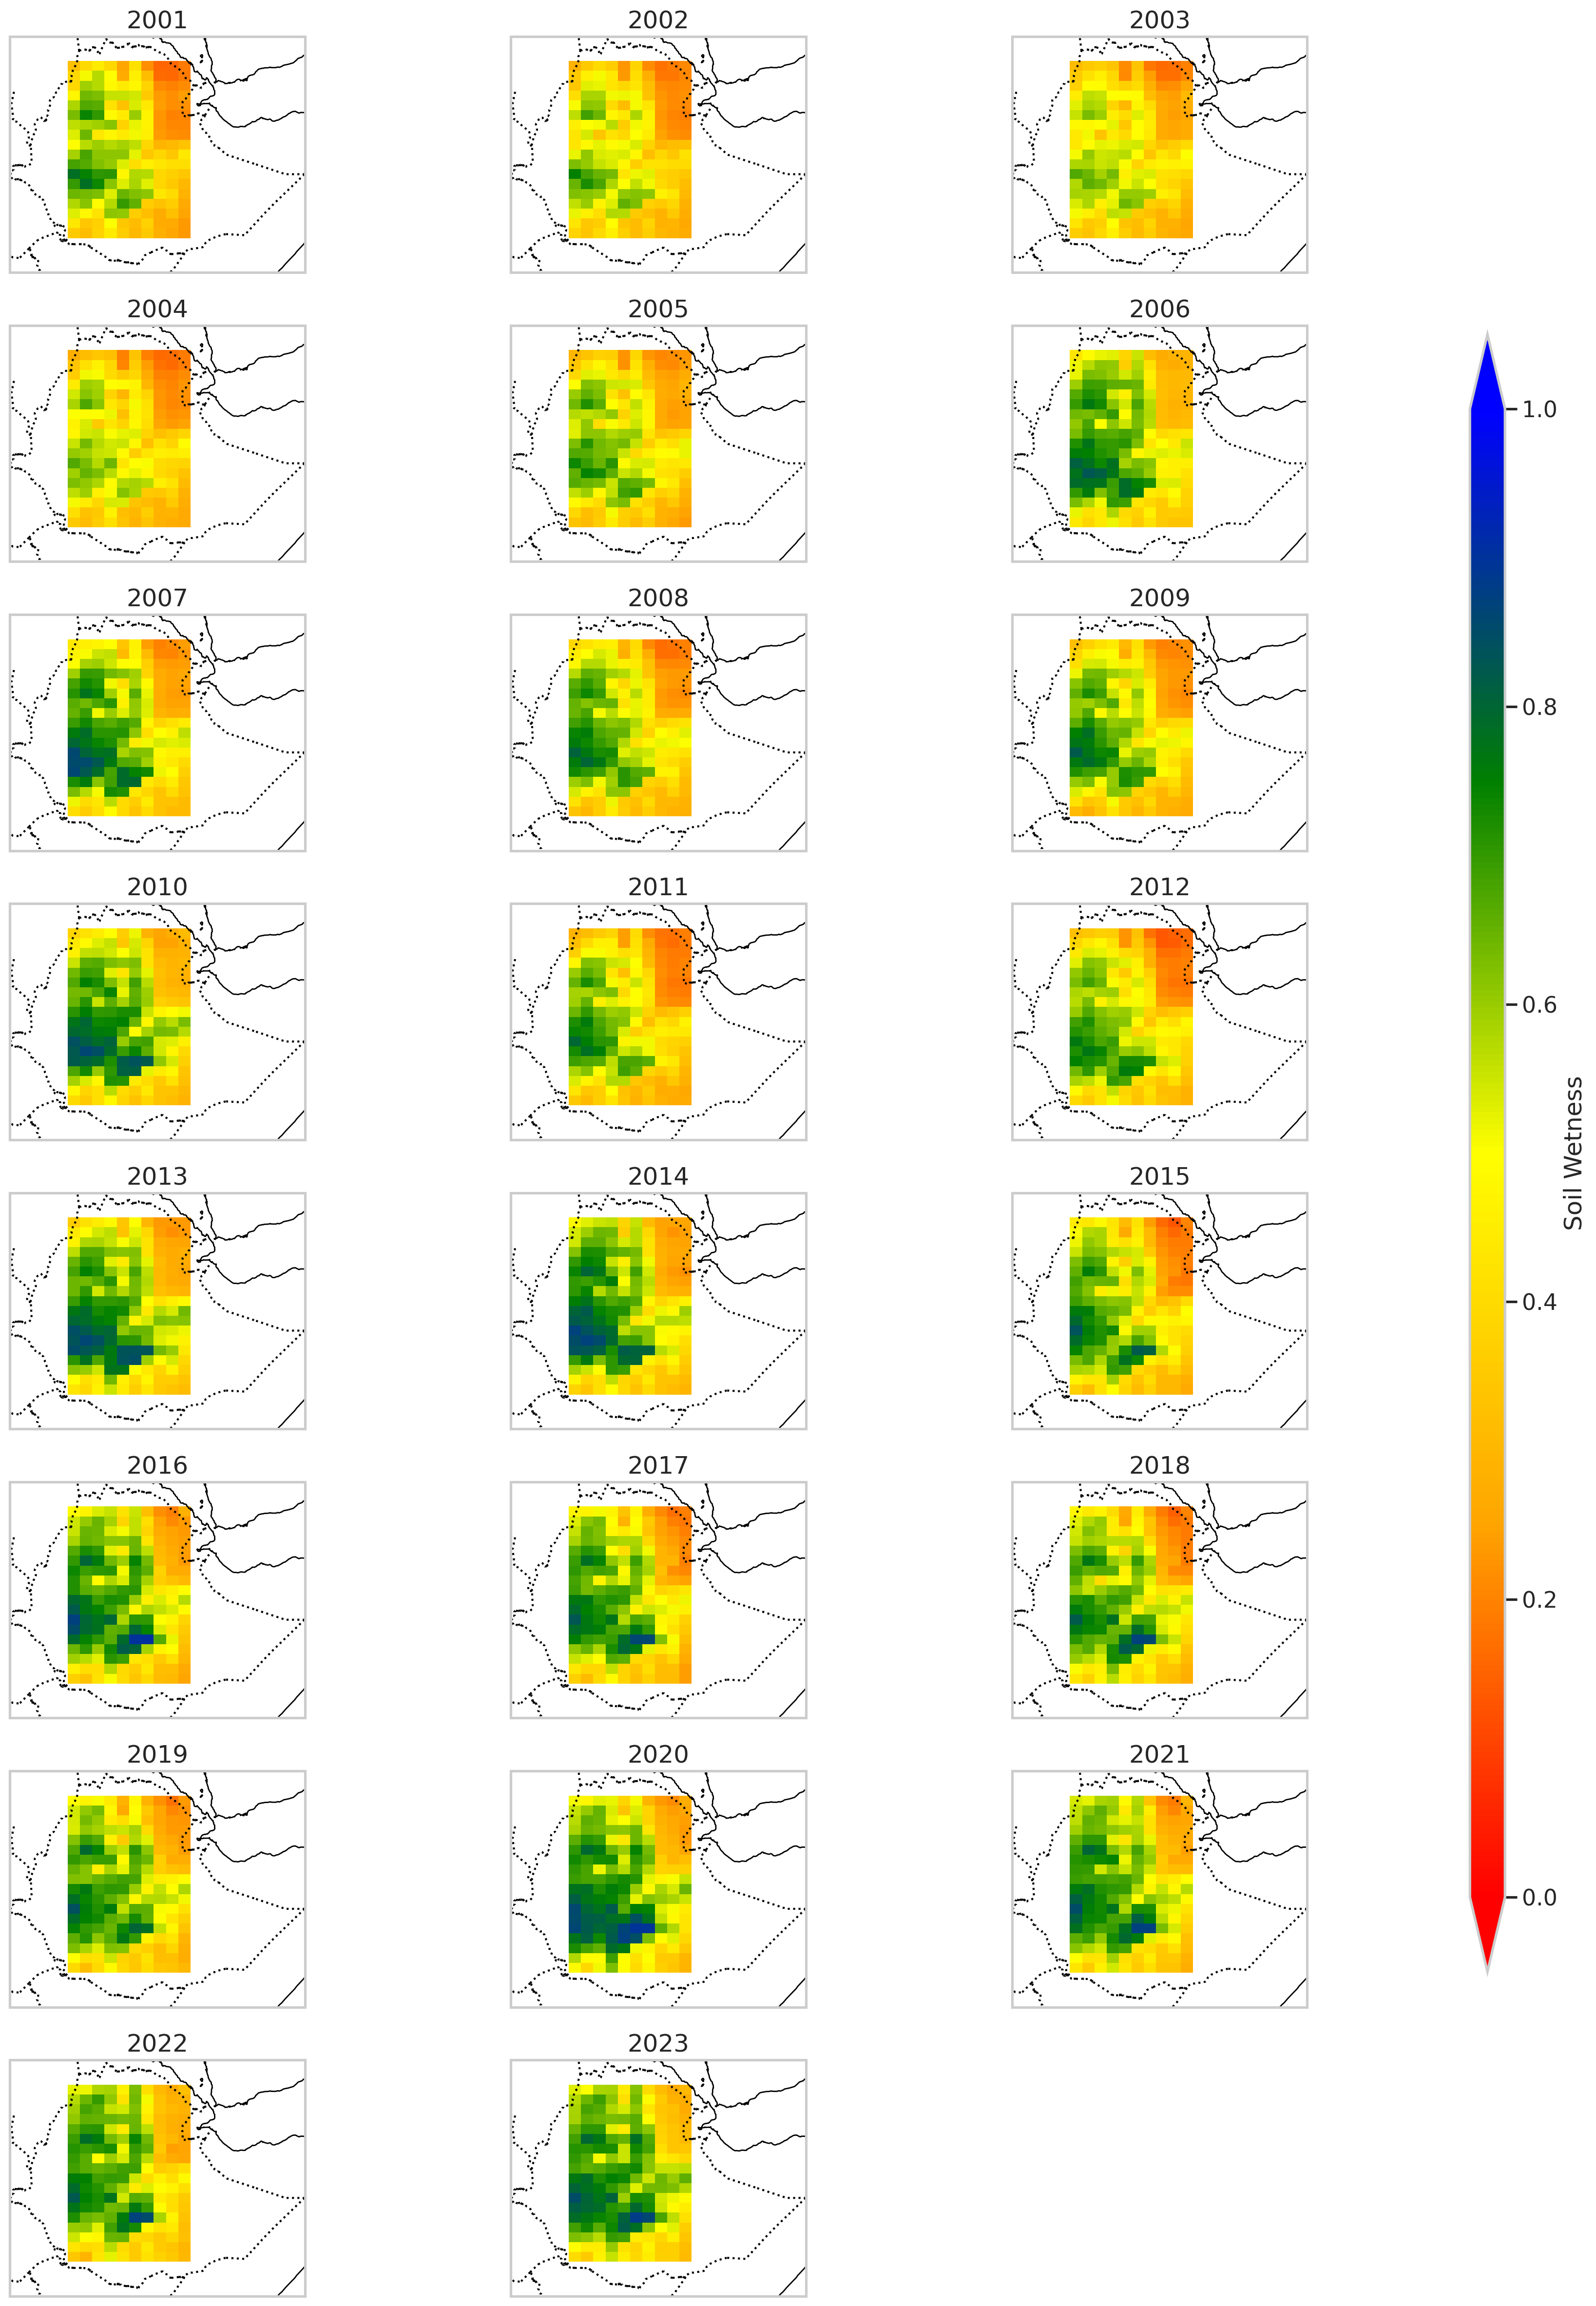

In [13]:
plot_yearly_data(yearly_soil_wetness)

### What is Root Zone Soil Wetness?
Root zone soil wetness, measured on a daily scale, is an indicator of the moisture content within the soil layer that extends from the surface to 100 centimeters (cm) below grade. This particular layer is crucial because it encompasses the majority of the root systems for many plants, making it vital for agricultural and hydrological monitoring.

In [10]:
# Convert daily data to monthly by averaging
yearly_data = ds.resample(timestamp='YE').mean()

# Computing monthly averages specifically for the GWETROOT variable
yearly_soil_wetness = ds['GWETROOT'].resample(timestamp='YE').mean()

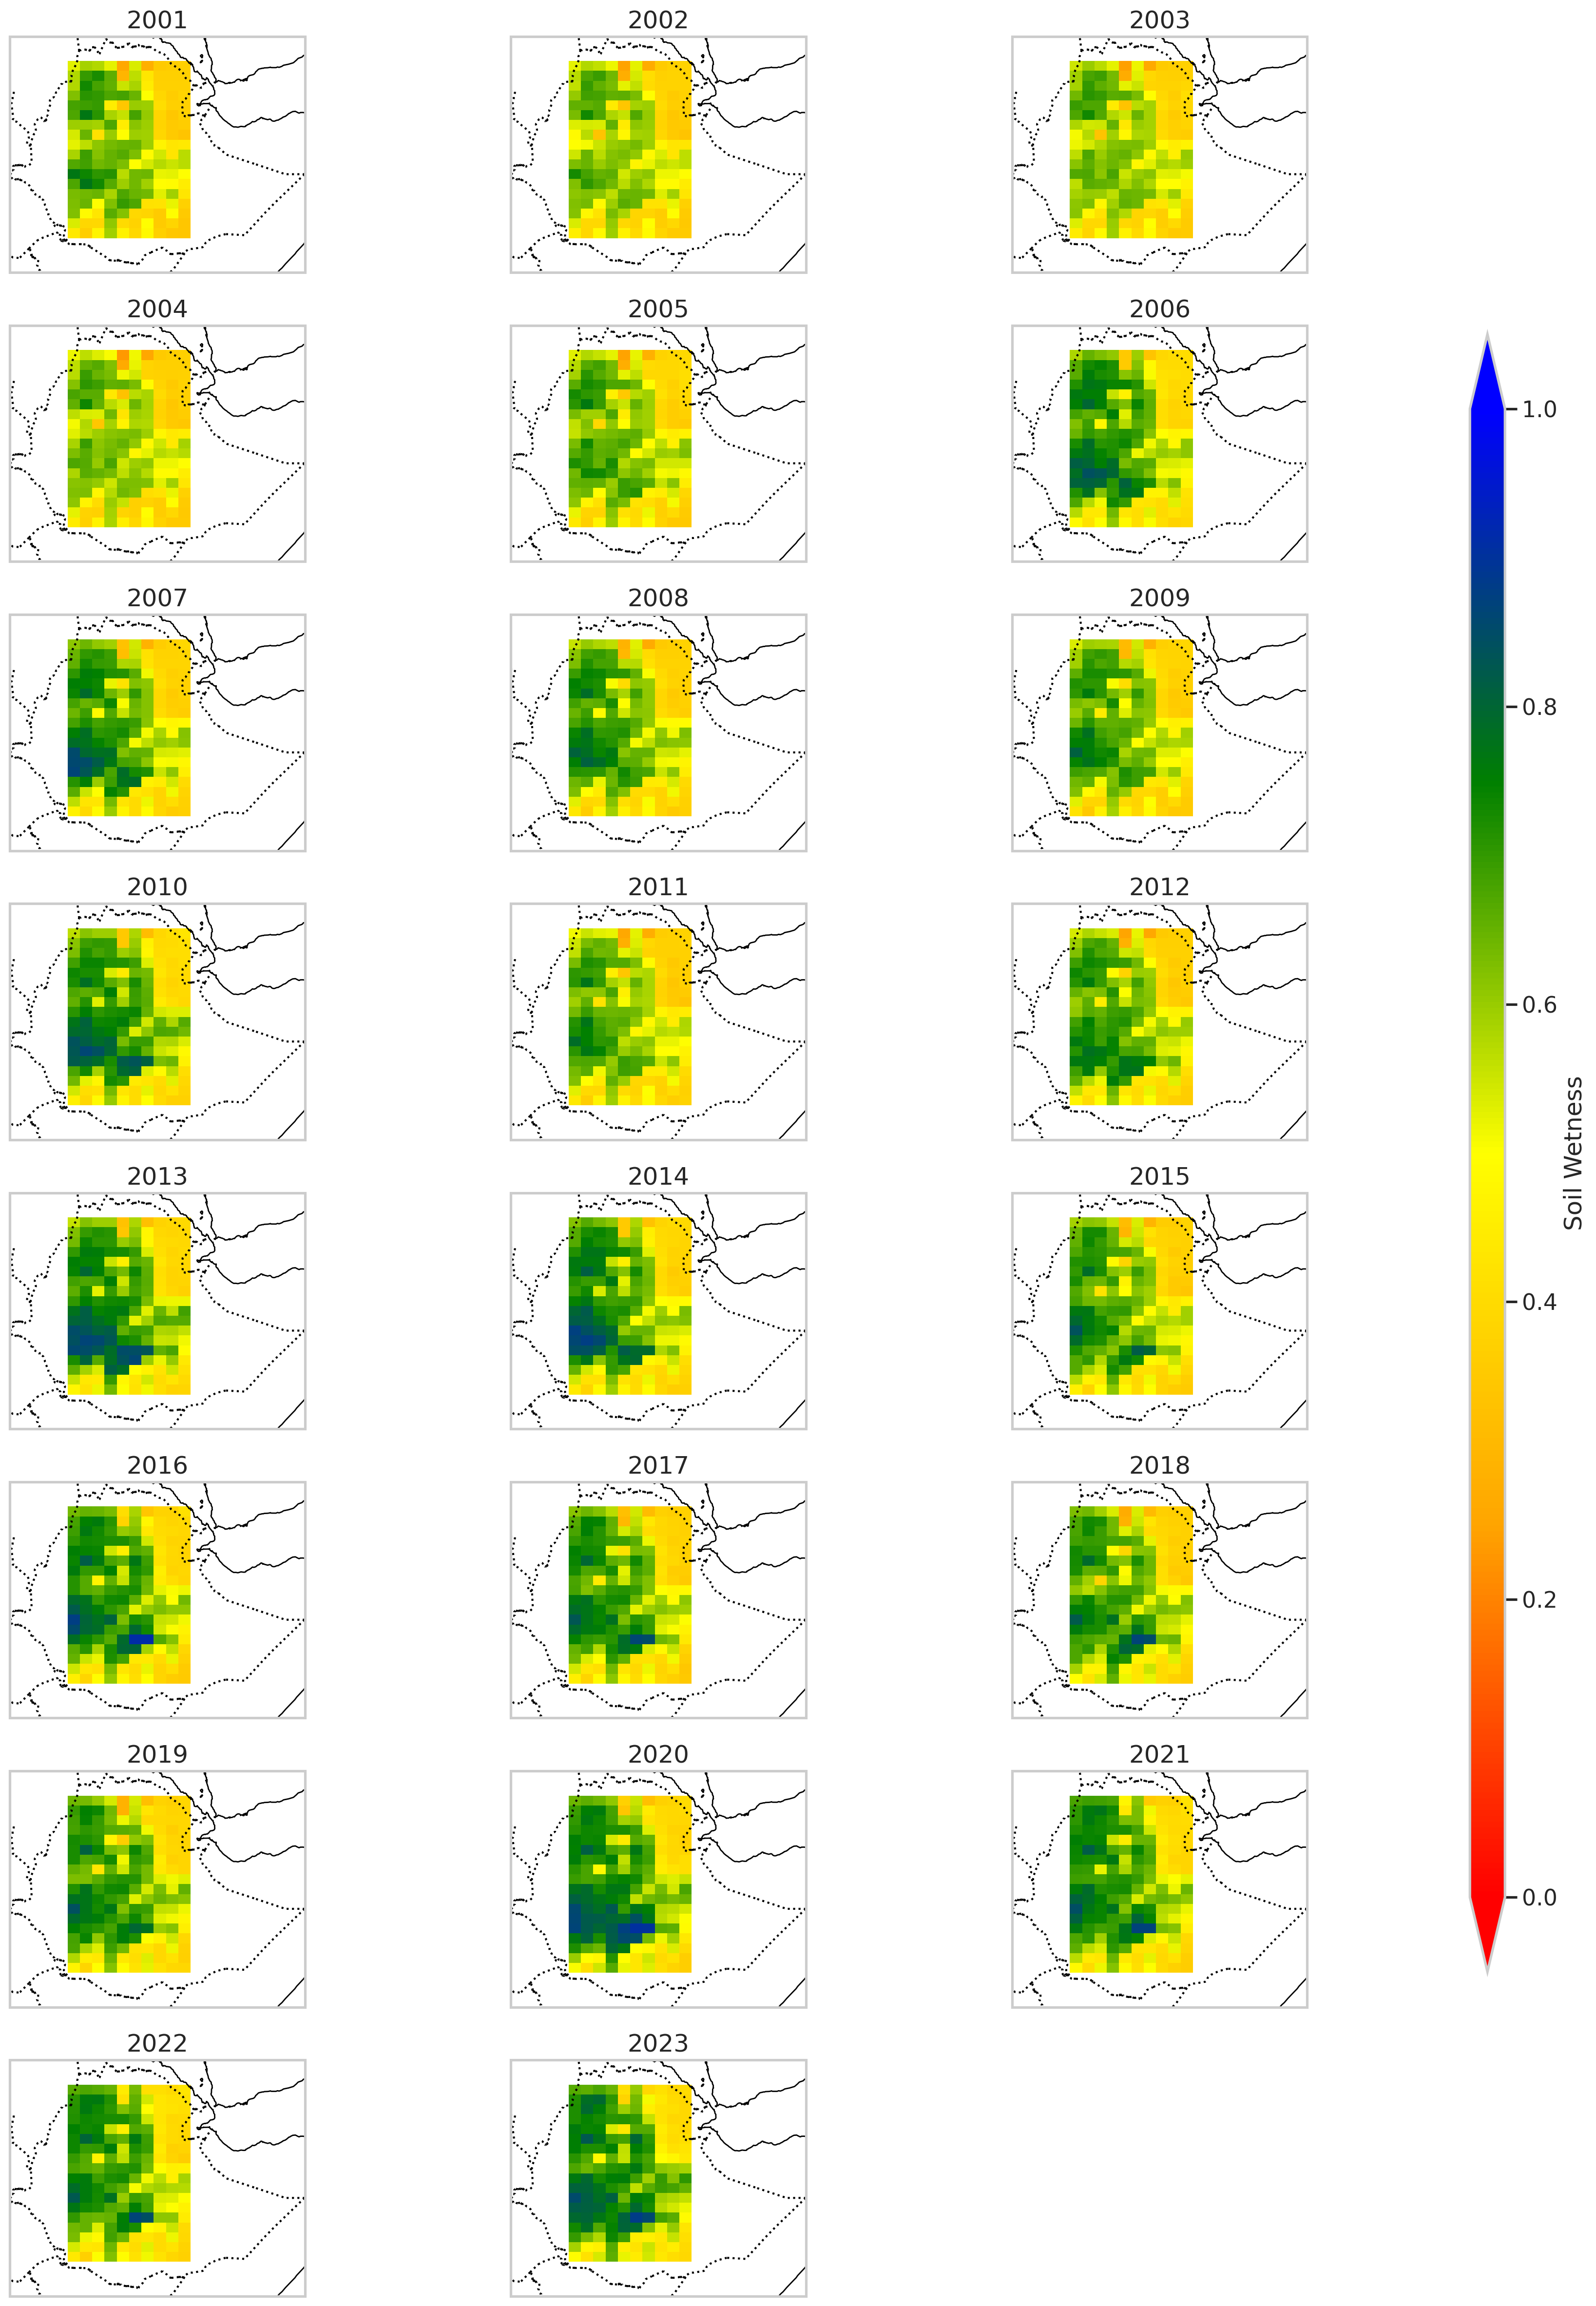

In [11]:
plot_yearly_data(yearly_soil_wetness)

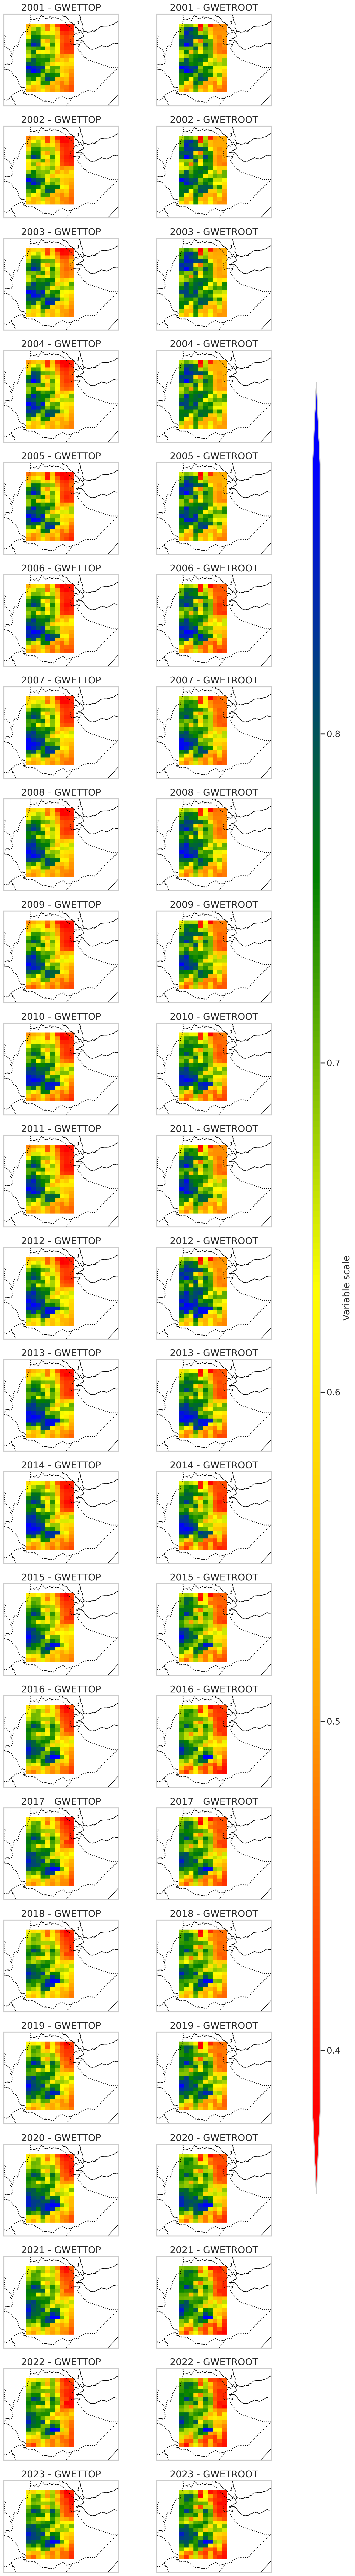

In [20]:
def plot_multiple_yearly_data(yearly_data, variables):
    """
    Plots multiple climate variables on geographical maps of Ethiopia for each year, enabling comparison across variables.

    Parameters:
    - yearly_data (xarray.Dataset): The dataset containing the climate data, resampled to yearly averages.
    - variables (list): A list of variable names to be plotted from the dataset.

    Each variable for each year is plotted in a row for easy comparison across variables, all within the geographic bounds of Ethiopia.
    """
    # Define a custom colormap from red (dry) to blue (wet)
    colors = ["red", "orange", "yellow", "green", "blue"]
    cmap = LinearSegmentedColormap.from_list("custom", colors, N=256)

    num_years = len(yearly_data.timestamp)
    ncols = len(variables)
    nrows = num_years
    fig = plt.figure(figsize=(5 * ncols, 3 * nrows), dpi=200)  # Width per column and height per row

    # Define the geographic extent of Ethiopia
    ethiopia_extent = [33, 48, 3, 15]  # [lon_min, lon_max, lat_min, lat_max]

    for i, year in enumerate(yearly_data.timestamp):
        for j, var in enumerate(variables):
            ax = fig.add_subplot(nrows, ncols, ncols * i + j + 1, projection=ccrs.PlateCarree())
            ax.coastlines(resolution='10m', color='black', linewidth=1)
            ax.add_feature(cfeature.BORDERS, linestyle=':')
            ax.set_extent(ethiopia_extent, crs=ccrs.PlateCarree())  # Set the extent to cover Ethiopia

            # Select data for the year and variable
            data = yearly_data[var].sel(timestamp=year)
            p = data.plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False,
                          vmin=data.min(), vmax=data.max(), cmap=cmap)

            ax.set_title(f'{year.dt.year.item()} - {var}')

    plt.tight_layout()
    # Add a colorbar with settings
    fig.subplots_adjust(right=0.92)
    cbar_ax = fig.add_axes([0.94, 0.15, 0.02, 0.7])
    fig.colorbar(p, cax=cbar_ax, label='Variable scale', extend='both')

    plt.show()

# Example of preparing data and calling the function
yearly_data = ds.resample(timestamp='1YE').mean()  # Resample your dataset to annual resolution

# Call the function with a list of variables you want to compare
plot_multiple_yearly_data(yearly_data, ['GWETTOP', 'GWETROOT'])


In [18]:
def decompose_seasonality_yearly(ds, variable_name):
    """
    Decomposes a given variable from an xarray.Dataset to analyze yearly seasonality.
    
    Parameters:
    - ds (xarray.Dataset): The dataset containing the variable.
    - variable_name (str): The name of the variable to analyze.
    
    This function performs the following steps:
    1. Averages the variable over latitude and longitude dimensions.
    2. Corrects negative values by setting them to zero.
    3. Converts the xarray.DataArray to a pandas DataFrame.
    4. Applies seasonal decomposition on the data with an annual cycle.
    5. Plots the observed data, trend, seasonal, and residual components.
    
    Returns:
    - None: Plots the decomposition components.
    """
    
    # Check if the variable exists in the dataset
    if variable_name not in ds.variables:
        raise ValueError(f"Variable {variable_name} not found in the dataset.")
    
    # Average over the latitude and longitude dimensions
    data = ds[variable_name].mean(dim=['lat', 'lon'])

    # Correct negative values by setting them to zero
    data = data.where(data >= 0, 0)

    # Convert to pandas DataFrame for easier handling in statsmodels
    data_df = data.to_dataframe(name=variable_name).dropna()

    # Decompose the time series to daily data with an annual cycle
    # If the data frequency is daily, use 365 or 366 for leap years
    decomposition = seasonal_decompose(data_df, model='additive', period=365)

    # Plot the decomposed components
    fig, axes = plt.subplots(4, 1, figsize=(12, 8))
    titles = ['Observed', 'Trend', 'Seasonal', 'Residual']
    for ax, component, title in zip(axes, [decomposition.observed, decomposition.trend, decomposition.seasonal, decomposition.resid], titles):
        component.plot(ax=ax, title=title)
        ax.set_ylabel(variable_name)
        ax.label_outer()  # Hide x-labels for top 3 plots for clarity
    plt.tight_layout()
    plt.show()

# Usage example:
# decompose_seasonality_yearly(ds, 'PRECTOTCORR')


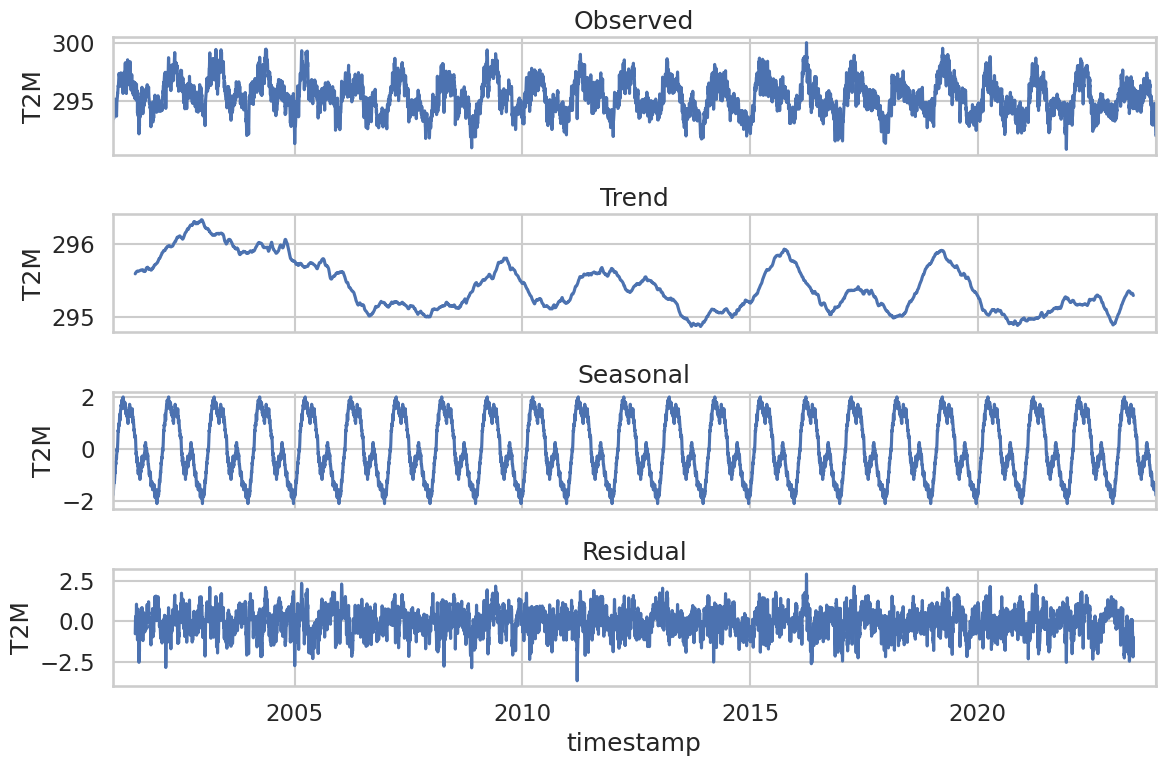

In [19]:
# Usage example:
decompose_seasonality_yearly(ds, 'T2M')